In [1]:
# подгрузим необходимые модули
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from IPython.display import display
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

RANDOM_SEED = 42 # фиксируем рандом
TEST_SIZE = 0.30 # размер валидационной выбоки


In [2]:
def describe_data(df):
    """сводная информация о датасете, описание параметров, пропуски, типы данных
    """
    DESCR = {
        "client_id": "id клиента",
        "app_date": "дата подачи",
        "education": "образования",
        "sex": "пол",
        "age": "возраст",
        "car": "автомобиль",
        "car_type": "иномарка",
        "decline_app_cnt": "отказы",
        "good_work": "хорошая работа",
        "score_bki": "балл БКИ",
        "bki_request_cnt": "запросы БКИ",
        "region_rating": "рейтинг региона",
        "home_address": "домашний адрес",
        "work_address": "рабочий адрес",
        "income": "доход",
        "sna": "связь с клиентами",
        "first_time": "давность информации о человеке",
        "foreign_passport": "загранпаспорт",
        "default": "дефолт",
    }
    display(
        pd.concat(
            [
                pd.Series(list(DESCR.values()), index=list(DESCR.keys()), name="description"),
                pd.Series(df.isnull().sum(), name="missed"),
                pd.Series(df.dtypes, name="type"),
                pd.Series(df.nunique(), name="nunique"),
                pd.Series([df[col].unique()[:5] for col in df.columns], index=df.columns, name="unique values"),
            ],
            axis=1,
        )
    )


def transform_binary(df):
    """преобразование yes/no и m/f в 1 и 0
    """
    yes_no = {"N": 0, "Y": 1, 0: 0, 1: 1}
    gender = {"M": 0, "F": 1, 0: 0, 1: 1}
    df.sex = df.sex.map(gender)
    df.car = df.car.map(yes_no)
    df.car_type = df.car_type.map(yes_no)
    df.good_work = df.good_work.map(yes_no)
    df.foreign_passport = df.foreign_passport.map(yes_no)


def plot_roc_curve(y_true, y_score):
    """построение ROC кривой и подсчет AUC
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"Regression")
    plt.plot([0, 1], [0, 1], lw=2, label="Baseline", linestyle="--")
    plt.title(f"ROC curve (AUC = {round(auc, 3)})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


def age_to_group(age):
    """разделение возраста на группы
    """
    if age < 26:
        return 1
    elif 26 <= age < 36:
        return 2
    elif 36 <= age < 55:
        return 3
    else:
        return 4


def plot_cmatrix(y, y_pred):
    """построение confusion матрицы в абсолютных и нормализованных значениях
    """
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    labels = [0, 1]
    cm = confusion_matrix(y, y_pred, labels=labels)
    cm_norm = confusion_matrix(y, y_pred, labels=labels, normalize="all")
    # cm_norm = confusion_matrix(y, y_pred, labels=labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp.plot(ax=axes[0])
    disp_norm.plot(ax=axes[1])
    plt.show()


def print_metrics(y_true, y_pred):
    """вывод метрик
    """
    print(f"accuracy: {round(accuracy_score(y_true,y_pred), 3)}")
    print(f"precision: {round(precision_score(y_true,y_pred), 3)}")
    print(f"recall_score: {round(recall_score(y_true,y_pred), 3)}")
    print(f"f1_score: {round(f1_score(y_true,y_pred), 3)}")


In [3]:
# загрузим данные и посмотрим их характеристику
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

describe_data(df_train)
describe_data(df_test)

,description,missed,type,nunique,unique values
client_id,id клиента,0,int64,73799,"[25905, 63161, 25887, 16222, 101655]"
app_date,дата подачи,0,object,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1..."
education,образования,307,object,5,"[SCH, GRD, UGR, PGR, ACD]"
sex,пол,0,object,2,"[M, F]"
age,возраст,0,int64,52,"[62, 59, 25, 53, 48]"
car,автомобиль,0,object,2,"[Y, N]"
car_type,иномарка,0,object,2,"[Y, N]"
decline_app_cnt,отказы,0,int64,21,"[0, 2, 1, 3, 4]"
good_work,хорошая работа,0,int64,2,"[0, 1]"
score_bki,балл БКИ,0,float64,69096,"[-2.00875292, -1.53227621, -1.40814226, -2.057..."


,description,missed,type,nunique,unique values
client_id,id клиента,0.0,int64,36349.0,"[74835, 17527, 75683, 26883, 28862]"
app_date,дата подачи,0.0,object,120.0,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0..."
education,образования,171.0,object,5.0,"[GRD, SCH, UGR, PGR, nan]"
sex,пол,0.0,object,2.0,"[M, F]"
age,возраст,0.0,int64,51.0,"[29, 39, 50, 56, 38]"
car,автомобиль,0.0,object,2.0,"[Y, N]"
car_type,иномарка,0.0,object,2.0,"[Y, N]"
decline_app_cnt,отказы,0.0,int64,19.0,"[0, 5, 3, 1, 2]"
good_work,хорошая работа,0.0,int64,2.0,"[0, 1]"
score_bki,балл БКИ,0.0,float64,34287.0,"[-2.27188367, -1.50499915, -1.69133904, -2.374..."


## Интуитивная модель

Сделаем минимальную обработку данных:
- дропнем пропуски в образовании
- дропнем дату подачи анкеты
- дропнем id клиента
- категориальные признаки превратим в dummy, бинарные в 0/1

и построим интуитивную модель

In [4]:
df_first_look = df_train.copy()  # df для модификации
df_first_look.drop(["client_id", "app_date"], axis=1, inplace=True)  # дропаем ненужные столбцы
df_first_look.dropna(inplace=True)  # дропаем пропуски
transform_binary(df_first_look)  # меняем  N/Y и F/M на 0/1
df_first_look = pd.get_dummies(df_first_look, columns=["education"])  # делаем dummy характеристики

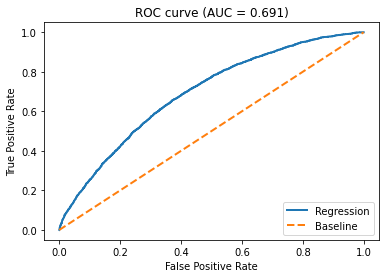

In [5]:
# бьем выборку, строим нативную модель и получем ROC
X = df_first_look[list(set(df_first_look.columns) - set(["default"]))]
y = df_first_look["default"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
plot_roc_curve(y_val, y_proba)

Данное значение AUC будем использовать как опорное значение

accuracy: 0.872
precision: 0.489
recall_score: 0.016
f1_score: 0.03


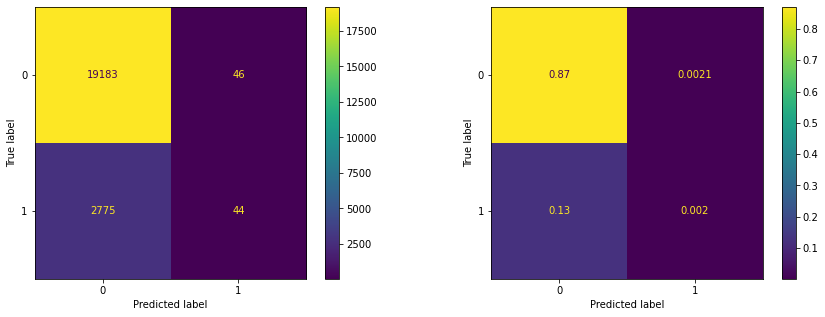

In [6]:
print_metrics(y_val, y_pred)
plot_cmatrix(y_val, y_pred)

## Pandas профайл

In [7]:
# сгерим отчет отчет по исходным данным
# profile = pandas_profiling.ProfileReport(df_train, title="Profiling Report")
# profile.to_file("sf-credit-scoring-alexigna.html")

Что видим из отчета:
1. client_id - в id клиента нет повторений и это просто идентификатор, его не будем включать в модель
2. app_date - нужно преобразовать дату обращения в dt, что с ней делать пока не понятно, но как минимум разбить на сезоны и/или рабочий/выходной день был и сколько дней прошло с подачи;
3. Бинарные признаки:
    - sex - меняем на 0/1, как в нативной модели
    - car - аналогично
    - car_type - аналогично + по описанию это машина иномарка, значит нужно проверить, что 1 стоит только там, где car стоит 1.
    - good_work - больше 80% не имееют хорошую работу, пока мыслей нет, оствляем как есть
    - foreign_passport - меняем на 0/1
4. Категориальные признаки
    - education - пропуски в образовании (меньше 0.5%), в принципе можно удалить такой малый объем, с другой стороны у нас школа составляет более 50%, да и скорее всего есть у всех как минимальный уровень, поэтому просто заполним пропуски наиболее частым занчением. Потом в dummy преобразовать, как в нативной модели
    - home_address - категориальный признак, с первого взгляда ничего можно не делать
    - work_address - аналогично
    - sna - аналогично
    - first_time - аналогично
5. Числовые признаки
    - age - средний возраст 39.2 лет, минимум 21, максимум 72. Хвост смещен влево, будем брать логарифм. Так же можно ввести группы по возрасту: <=25, 26-35, 36-55, >=56.
    - decline_app_cnt - хвост смещен влево - берем логарифм, + посколько больше 80% вообще не получало отказ, можно ввести доп признак, показывающий был ли хотя бы один отказ или нет
    - score_bki - по графику красивое распределение
    - bki_request_cnt - хвост смещен влево, берем логарифм, + я бы ввел еще один признак много/мало запросов. Скажем если  4 и более запросов, то это много. Вероятно человек бегает по банкам или у него проблемы с долгами
    - region_rating - возможно шкала была от 0 до 100 и рейтинг с шагом 10,
    - income - логарифмируем, + на текущих данных явно есть выбросы, посмотрим как будет на логарифмированных данных. Но предположительно можно ввести (или вообще заменить) income на диапазоны

# Дата

In [8]:
# преобразуем значение в dt формат
df_train.app_date = pd.to_datetime(df_train.app_date, format="%d%b%Y")
df_test.app_date = pd.to_datetime(df_test.app_date, format="%d%b%Y")

# добавим признак выходных
df_train["weekend"] = (df_train.app_date.dt.weekday // 5 == 1).astype(int)
df_test["weekend"] = (df_test.app_date.dt.weekday // 5 == 1).astype(int)

# посмотрим, какие месяцы есть в выборке, что бы понять, делать признак по кварталам/сезонам или оставлять месяцы
print(df_train.app_date.dt.month.value_counts())
print(df_test.app_date.dt.month.value_counts())

# видно, что только 4 месяца есть, поэтому о кварталах/сезонах речь не идет, оставляем просто месяц
df_train["month"] = df_train.app_date.dt.month
df_test["month"] = df_test.app_date.dt.month

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64
3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64


# Бинарные признаки

In [9]:
# bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# преобразуем значения
transform_binary(df_train)
transform_binary(df_test)

# проверим, что у нас нет иномарок, если нет машины вовсе
print(df_train[df_train.car == 0].car_type.value_counts())
print(df_test[df_test.car == 0].car_type.value_counts())


0    49832
Name: car_type, dtype: int64
0    24458
Name: car_type, dtype: int64


# Категориальные признаки

In [10]:
# cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

In [11]:
# заполняем пропуски в образовании на наиболее популярное значение
df_train.education.fillna(df_train.education.value_counts().index[0], inplace=True)
df_test.education.fillna(df_train.education.value_counts().index[0], inplace=True)

# делаем dummy характеристики из образования
df_train = pd.get_dummies(df_train, columns=["education"])
df_test = pd.get_dummies(df_test, columns=["education"])

# Числовые признаки

## age

In [12]:
# добавим группу возраста
df_train["age_gruop"] = df_train.age.apply(age_to_group)
df_test["age_gruop"] = df_test.age.apply(age_to_group)

# логарифмируем
df_train["age_log"] = df_train.age.apply(lambda age: np.log(age + 1))
df_test["age_log"] = df_test.age.apply(lambda age: np.log(age + 1))

## decline_app_cnt

In [13]:
# добавляем флаг хотя бы одного отказа
df_train["decline"] = (df_train.decline_app_cnt != 0).astype(int)
df_test["decline"] = (df_test.decline_app_cnt != 0).astype(int)

# логарифмируем
df_train["decline_log"] = df_train.decline_app_cnt.apply(lambda decline: np.log(decline + 1))
df_test["decline_log"] = df_test.decline_app_cnt.apply(lambda decline: np.log(decline + 1))

## bki_request_cnt

In [14]:
# добавляем флаг большого числа запросов
df_train["bki_request_many"] = (df_train.bki_request_cnt >= 4).astype(int)
df_test["bki_request_many"] = (df_test.bki_request_cnt >= 4).astype(int)

# логарифмируем
df_train["bki_request_cnt_log"] = df_train.bki_request_cnt.apply(lambda req: np.log(req + 1))
df_test["bki_request_cnt_log"] = df_test.bki_request_cnt.apply(lambda req: np.log(req + 1))

## income

In [15]:
# добавляем флаг большого дохода, взял Q3, 48000
df_train["income_big"] = (df_train.income >= 48000).astype(int)
df_test["income_big"] = (df_test.income >= 48000).astype(int)

# логарифмируем
df_train["income_log"] = df_train.income.apply(lambda income: np.log(income + 1))
df_test["income_log"] = df_test.income.apply(lambda income: np.log(income + 1))

# Оценим влияние числовых признаков

Text(0.5, 1.0, 'Significance of num variables')

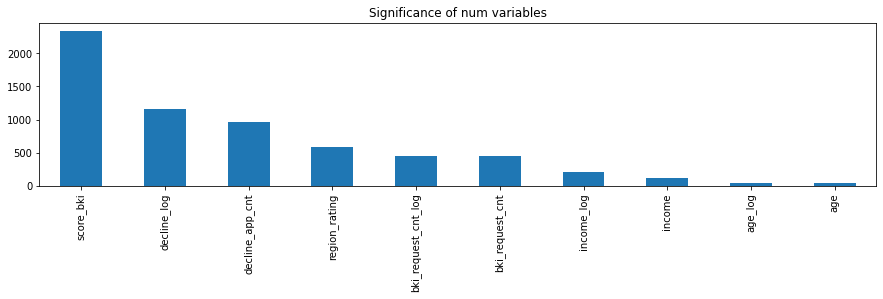

In [16]:
imp_cols = [
    "age",
    "age_log",
    "decline_app_cnt",
    "decline_log",
    "score_bki",
    "bki_request_cnt",
    "bki_request_cnt_log",
    "region_rating",
    "income",
    "income_log",
]

imp_num = pd.Series(
    f_classif(
        df_train[imp_cols],
        df_train["default"],
    )[0],
    index=imp_cols,
)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar", figsize=(15, 3))
plt.title("Significance of num variables")


score_bki наиболее влиятельный параметр, логотифм от признаков тоже оказались с бОльшим влиянием, чем оригинальные признаки. Оставим их и сформируем целевой набор параметров.

In [17]:
num_cols = list(set(imp_cols) - {"decline_app_cnt", "bki_request_cnt", "income", "age"})
final_cols = num_cols.copy()

# Оценим влияние бинарных и категориальных признаков

<AxesSubplot:>

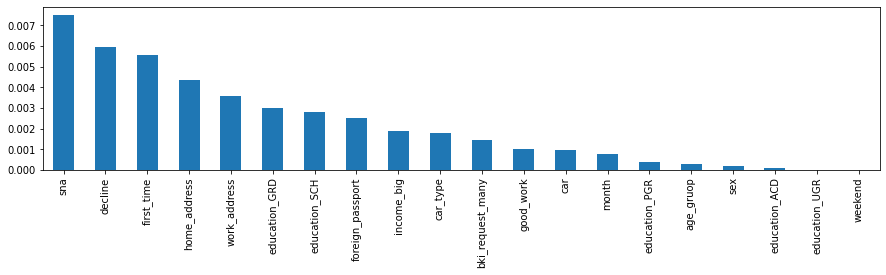

In [18]:
imp_cols = [
    "age_gruop",
    "bki_request_many",
    "car",
    "car_type",
    "decline",
    "education_ACD",
    "education_GRD",
    "education_PGR",
    "education_SCH",
    "education_UGR",
    "first_time",
    "foreign_passport",
    "good_work",
    "home_address",
    "work_address",
    "income_big",
    "month",
    "weekend",
    "sex",
    "sna",
]

imp_cat = pd.Series(
    mutual_info_classif(
        df_train[imp_cols],
        df_train["default"],
        discrete_features=True,
    ),
    index=imp_cols,
)
imp_cat.sort_values(inplace=True, ascending=False)
imp_cat.plot(kind="bar", figsize=(15, 3))


Тут уберем weekend, оказался не нужен, в отличии от месяца

In [19]:
cat_cols = list(set(imp_cols) - {"weekend"})
final_cols.extend(cat_cols)

# Обучение модели

In [20]:
# разбиение выборки на тестовую и валидационную
X = df_train[final_cols]
y = df_train["default"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# тестовые данные
X_test = df_test[final_cols]

In [21]:
# нормализация
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

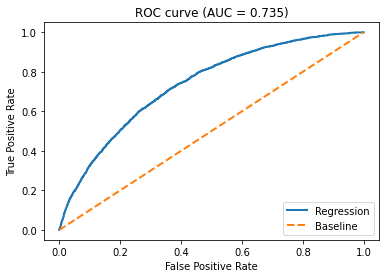

In [22]:
# обучаем модель и стром ROC кривую
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
plot_roc_curve(y_val, y_proba)

значение AUC получилось немного лучше, посмотрим еще на confusion matrix и метрики

accuracy: 0.873
precision: 0.416
recall_score: 0.024
f1_score: 0.046


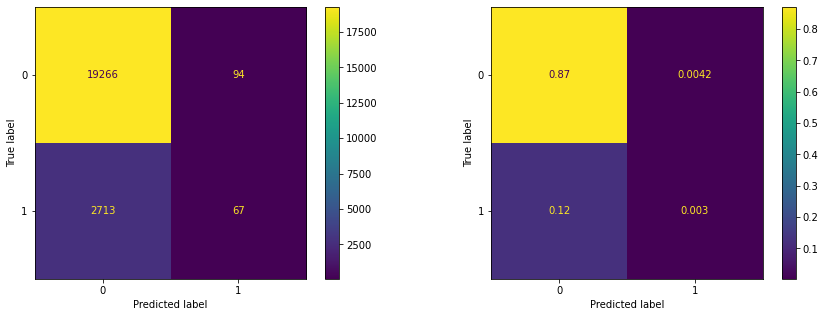

In [23]:
print_metrics(y_val, y_pred)
plot_cmatrix(y_val, y_pred)

12% предсказанных как не-дефолт, на самом деле оказались плохими заемщиками, это прямые потери, поэтом попробуем добавить региляризацию

# Регуляризация

In [24]:
hyperparameters = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "sag", "saga"],
}

model = LogisticRegression(penalty="l2", max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring="f1")

best_model = clf.fit(X_train, y_train)

print("Лучшее C:", best_model.best_estimator_.get_params()["C"])
print("Лучшей solver:", best_model.best_estimator_.get_params()["solver"])


Лучшее C: 0.01
Лучшей solver: liblinear


Используем полученные параметры и посмотрим на модель

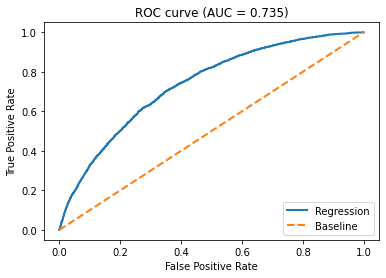

In [25]:
params = best_model.best_estimator_.get_params()
model = LogisticRegression(**params)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
plot_roc_curve(y_val, y_proba)

AUC не поменялся, посмотрим на confusion matrix и метрики

accuracy: 0.668
precision: 0.226
recall_score: 0.68
f1_score: 0.34


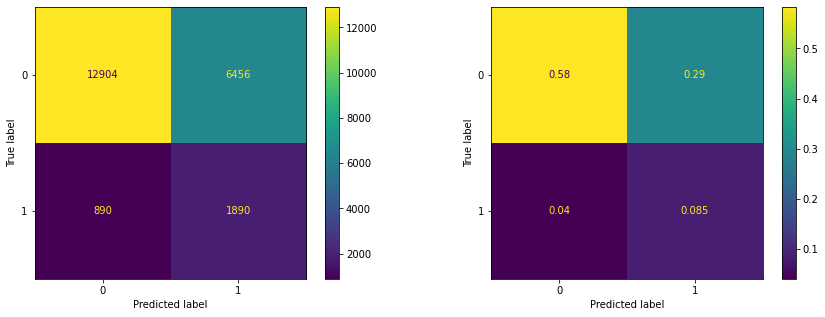

In [26]:
print_metrics(y_val, y_pred)
plot_cmatrix(y_val, y_pred)

В этом случае доля FN упала до 0.4%, что значительно луше. Но за счет увеличения FP, т.е. за счет бОльшего числа отказов хорошим клиентам.

# Submission

In [27]:
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = model.predict(X_test)

submission = df_test[["client_id"]].copy()
submission["default"] = y_proba_test
submission.to_csv("submission.csv", index=False)